# Titanic: Machine Learning from Disaster


## Original description

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

![titanic](titanic.png)

## Challenge

*The data has been split into two groups:*

* *training set (train.csv)*
* *test set (test.csv)*

*The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.*

*The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to **predict whether or not they survived the sinking of the Titanic**.*


## Variables

* PassengerId
* Survived: Survival (0 = No, 1 = Yes)
* Pclass: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
* Name
* Sex
* Age: In years
* SibSp: Number of siblings / spouses aboard the Titanic
* Parch: Number of parents / children aboard the Titanic
* Ticket: Ticket number
* Fare: Passenger fare
* Cabin: Cabin number
* Embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
set2 = sns.color_palette('Set2')

## Data Loading

In [2]:
train_data = pd.read_csv('train.csv', 
                         dtype = {'PassengerId':'object', 'Pclass':'object'})

train_data.drop(columns = ['Ticket'], inplace=True) # useless variable removed
train_data # head & tail

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,30.0000,C148,C


In [3]:
train_data.dtypes

PassengerId     object
Survived         int64
Pclass          object
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Fare           float64
Cabin           object
Embarked        object
dtype: object

# Exploration

In [4]:
# Summary
train_data.describe()

,Survived,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,29.699118,0.523008,0.381594,32.204208
std,0.486592,14.526497,1.102743,0.806057,49.693429
min,0.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# Percentage of missing values
train_data.isna().sum()/len(train_data)*100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [6]:
# Function to build histograms grouped by the target variable 'Survived'

def paired_hist(data, bivcol, numcol, tags, **kwargs):
    f1 = (train_data[bivcol]==0) & ~pd.isna(train_data[numcol])
    f2 = (train_data[bivcol]==1) & ~pd.isna(train_data[numcol])
    plt.hist(train_data[f1][numcol], color = 'red', alpha = 0.4, **kwargs)
    plt.hist(train_data[f2][numcol], color = 'blue', alpha = 0.4, **kwargs)
    
    plt.legend(tags)
    plt.xlabel(numcol)
    plt.tight_layout();

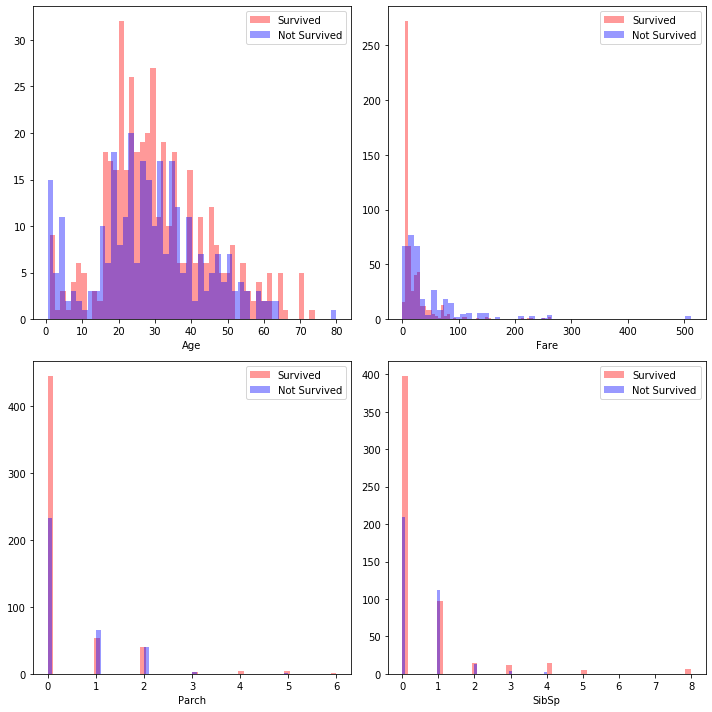

In [7]:
tags = ['Survived', 'Not Survived']

fig = plt.figure(figsize = (10,10))
fig.subplots_adjust(wspace = 0.25)

fig.add_subplot(221)
paired_hist(train_data, 'Survived', 'Age', tags, bins = 50)

fig.add_subplot(222)
paired_hist(train_data, 'Survived', 'Fare', tags, bins = 50)

fig.add_subplot(223)
paired_hist(train_data, 'Survived', 'Parch', tags, bins = 50)

fig.add_subplot(224)
paired_hist(train_data, 'Survived', 'SibSp', tags, bins = 50)

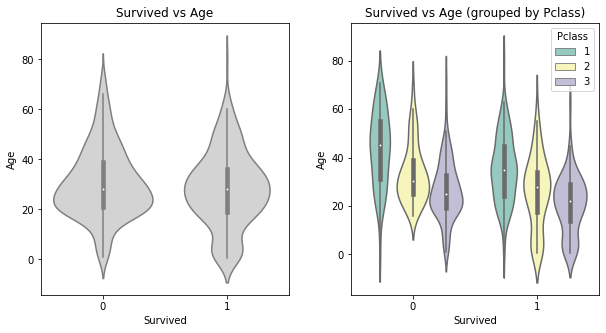

In [8]:
# Age - Survived violin plots with Seaborn

fig = plt.figure(figsize = (10,5))
fig.subplots_adjust(wspace = 0.25)

ax = fig.add_subplot(121)
sns.violinplot(x = 'Survived', y = 'Age', data = train_data, color = 'lightgrey')
plt.title('Survived vs Age')

ax = fig.add_subplot(122)
sns.violinplot(x = 'Survived', y = 'Age', hue = 'Pclass', data = train_data, palette = 'Set3')
plt.title('Survived vs Age (grouped by Pclass)');

In [9]:
# Embarked has only 1 missing value
# This is imputed using most frequent category

mode = train_data['Embarked'].mode()[0]
print('"Embarked" most frequent category: ' + mode)
train_data['Embarked'].fillna(mode, inplace = True)

"Embarked" most frequent category: S


Survived    0    1
Embarked          
C          75   93
Q          47   30
S         427  219


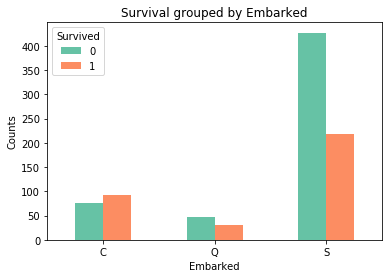

In [10]:
d = pd.crosstab(train_data['Embarked'], train_data['Survived'])
print(d)

# Grouped barplot with pandas
d.plot.bar(color = set2)
plt.title('Survival grouped by Embarked')
plt.ylabel('Counts')
plt.xticks(rotation = 0);

## Feature Engineering

### Name

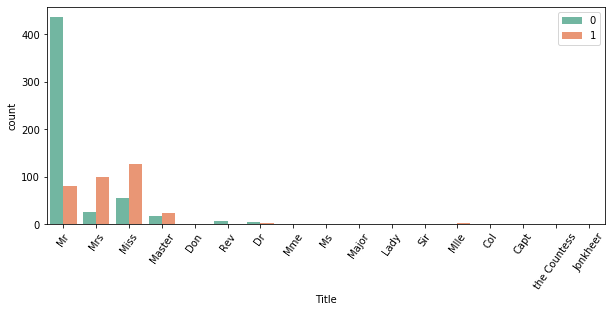

In [11]:
# Extracting Title from the name
plt.figure(figsize = (10,4))
title = [i.split(',')[1].split('.')[0].strip() for i in train_data['Name']]
train_data['Title'] = pd.Series(title) # Adding new variable: Title

# Grouped barplot with seaborn
g = sns.countplot(x = 'Title', hue = 'Survived', data = train_data, palette = 'Set2')
plt.legend(loc = 'upper right')
plt.xticks(rotation = 55);

# Alternative rotation:
# g = plt.setp(g.get_xticklabels(), rotation = 45)

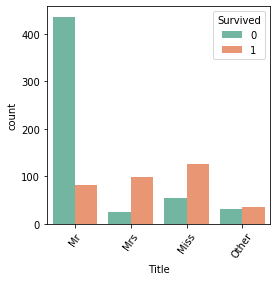

In [12]:
# Grouping low count titles into 'Other'
allowed = ['Mr', 'Mrs', 'Miss']
train_data.loc[~train_data['Title'].isin(allowed), 'Title'] = 'Other'

fig = plt.figure(figsize = (4,4))
g = sns.countplot(x = 'Title', hue = 'Survived', data = train_data, palette = 'Set2')
plt.xticks(rotation = 55);

In [13]:
# Totals
train_data['Title'].value_counts()

Mr       517
Miss     182
Mrs      125
Other     67
Name: Title, dtype: int64

### Cabin

In [14]:
# Assigned and non-assigned cabin
train_data.loc[~train_data['Cabin'].isnull(), 'Cabin'] = 'Assigned'
train_data.loc[train_data['Cabin'].isnull(), 'Cabin'] = 'NotAssigned'

In [15]:
train_data['Cabin'].head()

0    NotAssigned
1       Assigned
2    NotAssigned
3       Assigned
4    NotAssigned
Name: Cabin, dtype: object

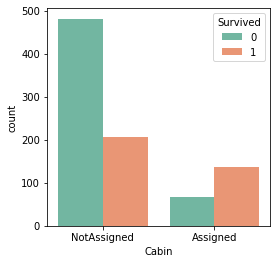

In [16]:
# d = pd.crosstab(train_data['Cabin'], train_data['Survived'])
# fig = d.plot.bar(stacked=False, width=0.30, color = set2)
# plt.xticks(rotation=0);

fig = plt.figure(figsize = (4,4))
g = sns.countplot(x = 'Cabin', hue = 'Survived', data = train_data, palette = 'Set2');

In [17]:
train_data['Cabin'].value_counts()

NotAssigned    687
Assigned       204
Name: Cabin, dtype: int64

## Data Preparation

In [18]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    object 
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    object 
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Fare         891 non-null    float64
 9   Cabin        891 non-null    object 
 10  Embarked     891 non-null    object 
 11  Title        891 non-null    object 
dtypes: float64(2), int64(3), object(7)
memory usage: 83.7+ KB


Transformation pipeline:
* Numeric variables: Imputation with median + Standardization
* Categorical variables: One hot encoding

In [19]:
from sklearn.pipeline import Pipeline

# Save numeric variables 
data_num = train_data[['Age', 'SibSp', 'Parch', 'Fare']]

# Pipeline for numeric variables
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())
])

# Save categorical variables
data_cat = train_data[['Pclass', 'Sex', 'Cabin', 'Embarked', 'Title']]

num_attribs = list(data_num)
cat_attribs = list(data_cat)
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])


In [20]:
data_prepared = full_pipeline.fit_transform(train_data)
data_prepared.shape

(891, 18)

## Building Machine Learning Algorithms

### K-Nearest Neighbours

In [21]:
# Train-test splitting

target = train_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(
data_prepared, target, random_state=0)

In [22]:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (668, 18)
y_train shape: (668,)
X_test shape: (223, 18)
y_test shape: (223,)


In [23]:
# Grid Search

param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 30, 70, 100],
    'p': [1, 2]
}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv = 10)

In [24]:
grid_knn.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [10, 30, 70, 100],
                         'n_neighbors': [3, 5, 7, 10, 15], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [25]:
# Evaluation

def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('Test set score: {:.2f}'.format(model.score(X_test, y_test)))
    print('Best parameters: {}'.format(model.best_params_))
    print('Best cross-validation score: {:.2f}'.format(model.best_score_))
    confusion = confusion_matrix(y_test, y_pred)
    print('Confusion matrix:\n{}'.format(confusion))
    print(classification_report(y_test, y_pred))

In [26]:
evaluate(grid_knn, X_test, y_test)

Test set score: 0.83
Best parameters: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}
Best cross-validation score: 0.83
Confusion matrix:
[[124  15]
 [ 24  60]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       139
           1       0.80      0.71      0.75        84

    accuracy                           0.83       223
   macro avg       0.82      0.80      0.81       223
weighted avg       0.82      0.83      0.82       223



### Logistic Regression

In [27]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'solver': ['newton-cg', 'lbfgs']
}
grid_logreg = GridSearchCV(LogisticRegression(max_iter = 1000), param_grid, cv = 10)
# Note that default regularization is L2

In [28]:
grid_logreg.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'solver': ['newton-cg', 'lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [29]:
evaluate(grid_logreg, X_test, y_test)

Test set score: 0.80
Best parameters: {'C': 10, 'solver': 'newton-cg'}
Best cross-validation score: 0.82
Confusion matrix:
[[113  26]
 [ 19  65]]
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       139
           1       0.71      0.77      0.74        84

    accuracy                           0.80       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.80      0.80      0.80       223



### Random Forest

In [30]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200]
}

grid_rf = RandomizedSearchCV(RandomForestClassifier(), param_grid, n_iter = 20, cv = 10)

In [31]:
grid_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
              

In [32]:
evaluate(grid_rf, X_test, y_test)

Test set score: 0.84
Best parameters: {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}
Best cross-validation score: 0.83
Confusion matrix:
[[125  14]
 [ 22  62]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       139
           1       0.82      0.74      0.78        84

    accuracy                           0.84       223
   macro avg       0.83      0.82      0.82       223
weighted avg       0.84      0.84      0.84       223



## Test Data

In [33]:
test_data = pd.read_csv('test.csv', 
                         dtype = {'PassengerId':'str', 'Pclass':'str'})
test_data.drop(columns = ['Ticket'], inplace=True)
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,NaN,S


In [34]:
test_data.describe()

,Age,SibSp,Parch,Fare
count,332.000000,418.000000,418.000000,417.000000
mean,30.272590,0.447368,0.392344,35.627188
std,14.181209,0.896760,0.981429,55.907576
min,0.170000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,7.895800
50%,27.000000,0.000000,0.000000,14.454200
75%,39.000000,1.000000,0.000000,31.500000
max,76.000000,8.000000,9.000000,512.329200


In [35]:
test_data.isna().sum()/len(train_data)*100

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age             9.652076
SibSp           0.000000
Parch           0.000000
Fare            0.112233
Cabin          36.700337
Embarked        0.000000
dtype: float64

## Transformations

Test data require the same modifications applied to train data in order to make the prediction effective.

In [36]:
# Grouping low count titles into 'Other'
title = [i.split(',')[1].split('.')[0].strip() for i in test_data['Name']]
test_data['Title'] = pd.Series(title)
allowed = ['Mr', 'Mrs', 'Miss']
test_data.loc[~test_data['Title'].isin(allowed), 'Title'] = 'Other'

In [37]:
# Assigned and non-assigned cabin
test_data.loc[~test_data['Cabin'].isnull(), 'Cabin'] = 'Assigned'
test_data.loc[test_data['Cabin'].isnull(), 'Cabin'] = 'NotAssigned'

**Transformation pipeline**

In [38]:
# Saving numeric and categorical variables
data_num = test_data[['Age', 'SibSp', 'Parch', 'Fare']]
data_cat = test_data[['Pclass', 'Sex', 'Cabin', 'Embarked', 'Title']]

In [39]:
# Applying transformations
num_attribs = list(data_num)
cat_attribs = list(data_cat)
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

test_prepared = full_pipeline.fit_transform(test_data)
test_prepared.shape

(418, 18)

### Preparing submission for Kaggle Competition

For the submission, I decided to use the Random Forest model. I will build the model again with the full dataset and the best parameters in order to maximize the prediction accuracy.

In [40]:
rf = RandomForestClassifier(**grid_rf.best_params_)

y = train_data['Survived'].values
X = data_prepared

rf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [41]:
y_pred = rf.predict(test_prepared)

submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': y_pred.tolist()
})

In [42]:
submission['Survived'].value_counts()

0    260
1    158
Name: Survived, dtype: int64

In [43]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [44]:
# Export to csv
submission.to_csv('submission.csv', header = True, index = False)